# IPSA 2021 - Exercise 3 - Fun with Fourier Transforms

## 0 - Practical Advice

In [1]:
import imageio 
import numpy as np
import numpy.fft as fft
import numpy.random as rnd
import scipy.ndimage as img
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

import timeit, functools

In [2]:
def imageScaleRange(f, vmin=0, vmax=255):
    '''Stretches the intensity values of a given image array f 
    such that they cover the whole range from 0 to 255'''
    return np.interp(f, (f.min(), f.max()), (vmin, vmax))

def imageRead(imgname, pilmode ='L', arrtype=float):
    """
    Read an image file into a numpy array

    imgname: str
        name of image file to be read
    pilmode: str
        for luminance / intesity images use ’L’
        for RGB color images use ’RGB’
    
    arrtype: numpy dtype
        use np.float, np.uint8, ...
    """
    return imageio.imread(imgname, pilmode=pilmode).astype(arrtype)

def imageWrite(arrF, imgname, arrtype=np.uint8):
    """
    Write a numpy array as an image file 
    the file type is inferred from the suffix of parameter imgname, e.g. ’.png’
    arrF: array_like
        array to be written
    imgname: str
        name of image file to be written
    arrtype: numpy dtype
        use np.uint8, ...
    """
    imageio.imwrite(imgname, arrF.astype(arrtype))

## 1 - Uni-variate Gaussians and their derivatives

An unnormalized, uni-variate Gaussian function $f : \mathbb{R} \rightarrow \mathbb{R}$ with location parameter $\mu \in \mathbb{R}$ and scale parameter $\sigma \in \mathbb{R}_+$ is given by
\begin{equation}
f(x \mid \mu, \sigma) = \exp \left( - \frac{(x - \mu)^2}{2 \, \sigma^2}\right) = e^{- \frac{1}{2 \, \sigma^2} (x - \mu)^2}
\end{equation}
The following plot was created with parameters $\mu = 0$ and $\sigma \in \{ 0.5, 1.0, 2.0\}$ and illustrates how such functions look like for $x \in [-7, +7)$

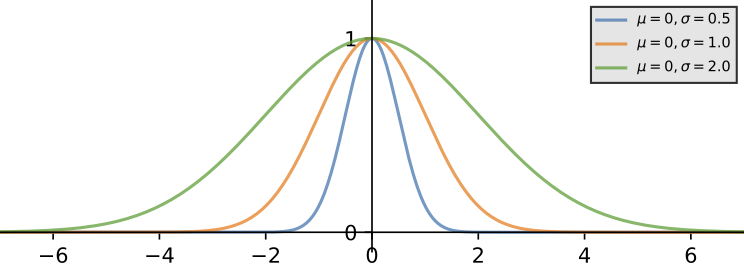

**task 3.1(a)** Compute the (symbolic) derivative of the Gaussian function:

Using the chain rule: 
$$ f(x) = e^{u(x)} \text{ and } f'(x) = u'(x) * e^{u(x)} $$

We can compute the derivative of the Gaussian function as:
\begin{equation}
\frac{d}{dx} f(x \mid \mu, \sigma) = \frac{(\mu - x)}{\sigma^2} f(x \mid \mu, \sigma)
\end{equation}

In [3]:
def plotFcts(x, fs,
             labs=None, lfs='x-small',
             xtcs=None, ytcs=None,
             lims=None, fname=None, title=None):

    # initialize figure and axes
    fig = plt.figure()
    axs = fig.add_subplot(211, facecolor='w')

    # nicer way of showing coordinate axes
    for pos in ['left','bottom']:
        axs.spines[pos].set_position('zero')
    for pos in ['right','top']:
        axs.spines[pos].set_visible(False)
        
    
    for f in fs:
        axs.plot(x, f, '-', alpha=0.75)

        
    if labs is not None:
        axs.legend(labs, loc="upper right", fontsize=lfs,
                   facecolor='#e0e0e0', edgecolor='k', fancybox=False)

    if xtcs is not None: axs.set_xticks(xtcs)
    if ytcs is not None: axs.set_yticks(ytcs)
        
    if lims is not None:
        axs.set_xlim(lims[0], lims[1])
        axs.set_ylim(lims[2], lims[3])
        
    if title:
        plt.title(title)
        
        
    # show figure on screen or write it to disc
    plt.show() if fname is None else writeFigure(fig, fname)
    plt.close()

def fctG(x, mu=0., sig=1.):
    """Gaussian function"""
    return np.exp(-0.5 * (x-mu)**2 / sig**2)

def ddxG(x, mu=0., sig=1.):
    """Derivative of the Gaussian function"""
    return -(x-mu) / sig**2 * fctG(x, mu, sig)

**3.1(b)** Use your result and the same parameters as above to create a plot that shows Gaussian derivatives and enter it here:

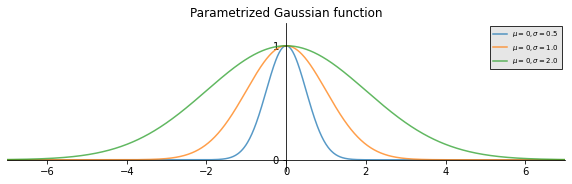

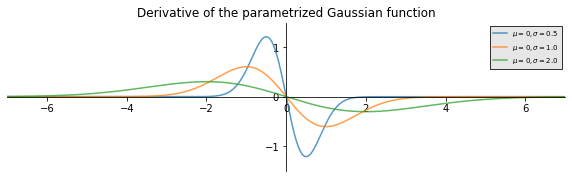

In [4]:
xmin = -7
xmax = +7
rate = 1024
xval = np.linspace(xmin, xmax, rate, endpoint=False)


sigs = [0.5, 1.0, 2.0]
labs = [r'$\mu = 0, \sigma = %.1f$' % sig for sig in sigs]



### plot three Gaussians
fcts = [fctG(xval, sig=sig) for sig in sigs]

lims = [xmin, xmax, -0.1, 1.2]
xtcs = np.arange(xmin+1, xmax, 2)
ytcs = [-1, 0, +1]
plotFcts(xval, fcts, labs=labs,
         xtcs=xtcs, ytcs=ytcs, lims=lims, title="Parametrized Gaussian function")



### plot their derivatives
fcts = [ddxG(xval, sig=sig) for sig in sigs]

lims = [xmin, xmax, -1.5, 1.5]
xtcs = np.arange(xmin+1, xmax, 2)
ytcs = [-1, 0, +1]
plotFcts(xval, fcts, labs=labs,
         xtcs=xtcs, ytcs=ytcs, lims=lims, title="Derivative of the parametrized Gaussian function")

## 2 - Working with Labraries for Symbolic Computing

In this course, we work extensively with the python modules `numpy` / `scipy` because they provide numerous functionalities for numerical computing and number crunching. However, during the lectures, we also mentioned software for symbolic computation. Maybe you have come across such software before? Maybe you have heard of Wolfram Mathematica? For python, functionalities for symbolic computation are provided by the `sympy` module. To see what it buys you, execute the following snippet:

In [5]:
! if conda list | grep sympy; then echo 1; else conda install -y sympy; fi

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/vtoborek/opt/miniconda3/envs/vision

  added / updated specs:
    - sympy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    gmp-6.2.1                  |       h23ab428_2         512 KB
    mpc-1.1.0                  |       h6ef4df4_1          84 KB
    mpfr-4.0.2                 |       h9066e36_1         433 KB
    mpmath-1.2.1               |   py39hecd8cb5_0         763 KB
    sympy-1.9                  |   py39hecd8cb5_0         9.3 MB
    ------------------------------------------------------------
                                           Total:        11.0 MB

The following NEW packages will be INSTALLED:

  gmp            

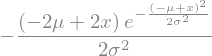

In [10]:
from sympy import *
from IPython.display import display

init_printing(use_unicode=True)

x, mu, sigma = symbols('x mu sigma')

fctF = exp(-(x-mu)**2 / (2*sigma**2))

ddxF = Derivative(fctF, x)

display(ddxF.doit())

## 3 - Fourier Transforms of Gaussians and their Derivatives

**Note:** in what follows, we will (for convenience) simplify the Gaussian as well as our notation for this function. First of all, we will drop the location parameter $\mu$ (when creating the plots in task 3.1, we did set it to $0$ anyway). Second of all, we will no longer explicitly write the dependence on the scale parameter $\sigma$. In short, in what follows, we are concerned with Gaussians of the form:
\begin{equation}
f(x) = \exp \left( - \frac{x^2}{2 \, \sigma^2}\right) = e^{- \frac{1}{2 \, \sigma^2} x^2}
\end{equation}  

Observe that Gaussian functions are square integrable and therefore have Fourier transforms. In fact, the Fourier transforms of Gaussians centered at $0$, i.e. without location parameter $\mu$, are remarkably simple. While the Fourier transform $F(\omega)$ of a function $f(x)$ is typically a complex valued function, the Fourier transform of a Gaussian centered at $0$ is a real valued function. You can work this out for yourselves.

## 4 - Numerically computing Fourier Tranforms of Gaussians

## 5 - Visualizing 2D Fourier transforms

## 6 - Exploring the Importance of Phase

## 7 - Low-pass Filtering in the Frequency Domain